<a href="https://colab.research.google.com/github/SiddharthRC/autoforecasting/blob/master/SidRC_GP_autoForecast_M4_MonthlyDataset_ManualKernelFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

mplementing kernels designed in Automatic forecasting using Gaussian Process [1] and test results with the M4 dataset. For now, only small sections of the M4 training and testing datasets are being used.



# Data loading and visualization
The data is available at the following path.

In [68]:
from pandas.core.groupby.generic import DataFrameGroupBy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
!pip install gpytorch # This is to allow gpytorch to work on any Google Colab Notebook
import gpytorch as gp
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Setting up the full m4 dataset and any subsets (ex. monthly, weekly, hourly, etc.) that might be analyzed.

In [69]:
random.seed(0)
df = pd.read_csv('/content/M4-info.csv') # This is for the m4 dataset as a whole
df_test = pd.read_csv("/content/Monthly-test.csv") # Monthly dataset for testing purposes
df_train = pd.read_csv("/content/Monthly-train.csv") # Monthly dataset for training purposes

In [70]:
df # Just to review the M4_Info dataset

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


In [71]:
df_train # Good too see how the training set compares to the info set.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,M47996,9964.0,7212.0,7858.0,8493.0,8203.0,8362.0,7238.0,7357.0,8642.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47996,M47997,1696.6,1627.2,1465.4,1672.8,1760.1,1974.8,1733.7,1898.0,1952.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47997,M47998,5900.0,6000.0,6280.0,6100.0,5410.0,5320.0,5130.0,5330.0,5810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47998,M47999,4660.0,4980.0,5060.0,5090.0,4790.0,4840.0,4640.0,4770.0,4940.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_test # Good too see how the testing set compares to the info set.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,M1,8720.0,7790.0,4770.0,5060.0,4720.0,4450.0,5120.0,5960.0,6560.0,4900.0,4520.0,7370.0,9050.0,7780.0,5380.0,4700.0,4490.0,4010.0
1,M2,2090.0,2180.0,1760.0,2290.0,1500.0,1370.0,1810.0,1450.0,1370.0,1380.0,1710.0,2140.0,1870.0,1670.0,1800.0,1800.0,1790.0,1600.0
2,M3,13314.0,13659.0,13839.0,13693.0,13701.0,13881.0,13862.0,13774.0,13677.0,13944.0,14023.0,13793.0,13752.0,13818.0,13901.0,14057.0,14037.0,14158.0
3,M4,6505.0,6559.0,6526.0,6499.0,6495.0,6450.0,6458.0,6434.0,6445.0,6382.0,6390.0,6390.0,6353.0,6337.0,6280.0,6284.0,6397.0,6433.0
4,M5,4390.0,4470.0,4350.0,4420.0,4480.0,4440.0,4340.0,4280.0,4210.0,4280.0,4350.0,4290.0,4320.0,4370.0,4390.0,4480.0,4390.0,4380.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,M47996,4405.9,5119.8,5993.1,6150.6,6845.0,3812.0,4503.0,3898.0,3988.0,3553.0,2514.0,2102.0,2548.0,2601.0,2831.0,3239.0,3825.0,1535.0
47996,M47997,1009.7,902.6,896.5,905.1,884.2,623.0,695.7,707.1,742.3,698.9,656.7,672.0,703.0,619.7,615.1,653.5,663.7,400.5
47997,M47998,5050.0,5010.0,4960.0,4940.0,4970.0,5010.0,5100.0,5090.0,5030.0,4940.0,4860.0,4880.0,4830.0,5030.0,4900.0,4790.0,5260.0,5100.0
47998,M47999,4390.0,4380.0,4400.0,4380.0,4410.0,4380.0,4470.0,4460.0,4400.0,4460.0,4380.0,4440.0,4300.0,4360.0,4340.0,4390.0,4570.0,4480.0


Select series_id for one product, and we'll fit GP as a univariate model. Code not used for now.

In [73]:
''' Code Not Used as datasets are set up separately. Might used later if applicable
series_id = 'M2573'
num_test = 18
df = df[df['M4id']==series_id] # M4id corresponds to the series_id in the original m3 dataset.
df
'''

" Code Not Used as datasets are set up separately. Might used later if applicable\nseries_id = 'M2573'\nnum_test = 18\ndf = df[df['M4id']==series_id] # M4id corresponds to the series_id in the original m3 dataset.\ndf\n"

## Setting a new dataset with one row from the training dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the training dataset.


In [74]:
df_2 = df_train.loc[2574].to_frame() # This is a dataframe housing the row that I chose, which I believe is the one with the most elements.
df_2 = df_2.dropna()
df_2 = pd.DataFrame(df_2) # Just confirming that we made a new dataframe
df_2["index"] = df_2.index # There are the indexes corresponding to each element
items = df_2.iloc[:, 0]
df_2 = df_2.assign(items=items)
df_2 = df_2.drop("V1")
df_2['index'] = df_2['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
df_2

,2574,index,items
V2,4200.0,2,4200.0
V3,4218.0,3,4218.0
V4,4200.0,4,4200.0
V5,4200.0,5,4200.0
V6,4221.0,6,4221.0
...,...,...,...
V1850,12655.0,1850,12655.0
V1851,12324.0,1851,12324.0
V1852,12386.0,1852,12386.0
V1853,12260.0,1853,12260.0


Text(0, 0.5, 'Value')

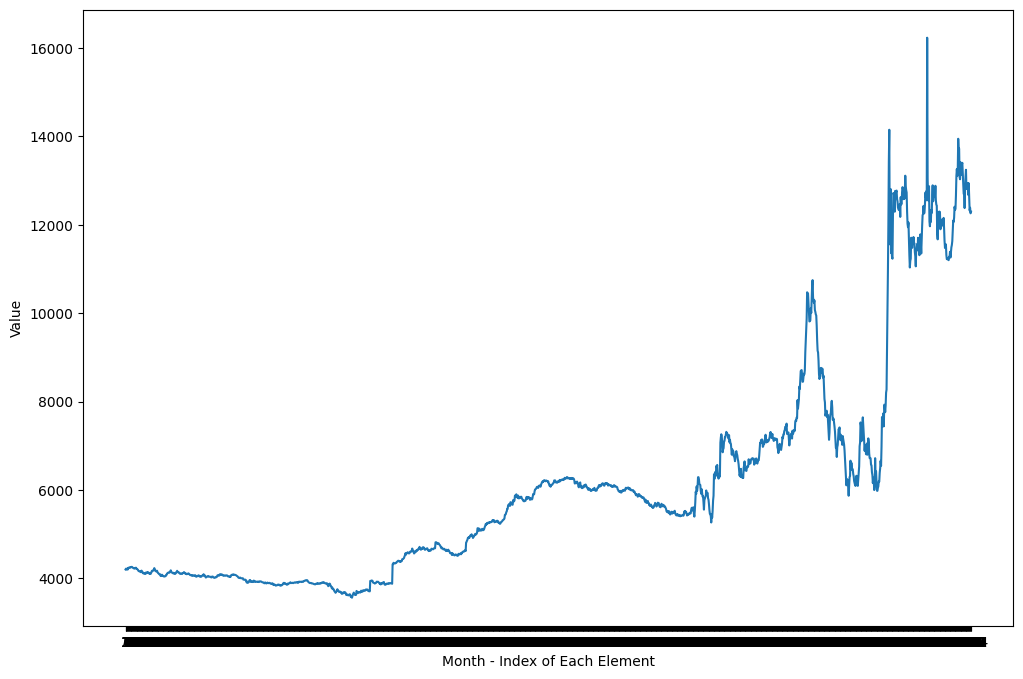

In [75]:
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_2) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

## Plotting the auto-correlation
We plot the auto correlcation function below.

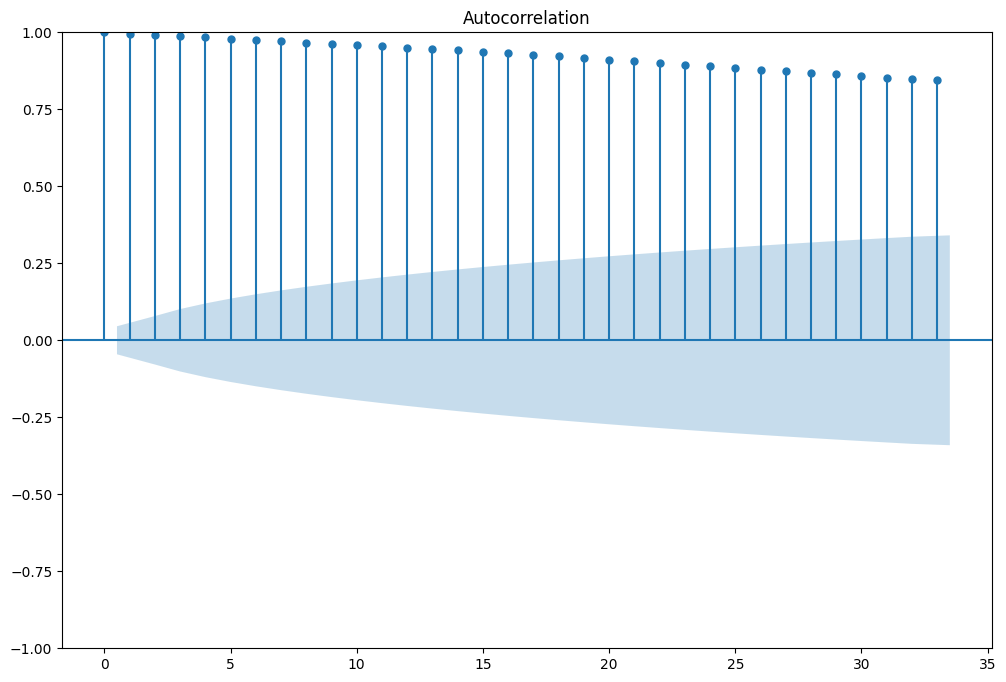

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(df_2['items'])

## Setting a new dataset with one row from the testing dataset
We visualize the data of one row in the M4 dataset and put that rows into its own dataset, which will now be used for the testing dataset.


In [77]:
df_3 = df_test.loc[2574].to_frame() # This is a dataframe housing the row that I chose.
df_3 = df_3.dropna()
df_3 = pd.DataFrame(df_3) # Just confirming that we made a new dataframe
df_3["index"] = df_3.index # There are the indexes corresponding to each element
items = df_3.iloc[:, 0]
df_3 = df_3.assign(items=items)
df_3 = df_3.drop("V1")
df_3['index'] = df_3['index'].str.replace('V', '') # Removing V from each index so that indecies are numbers
df_3


,2574,index,items
V2,12445.0,2,12445.0
V3,12322.0,3,12322.0
V4,12236.0,4,12236.0
V5,12086.0,5,12086.0
V6,11909.0,6,11909.0
V7,11800.0,7,11800.0
V8,11627.0,8,11627.0
V9,11436.0,9,11436.0
V10,11417.0,10,11417.0
V11,11400.0,11,11400.0


Text(0, 0.5, 'Value')

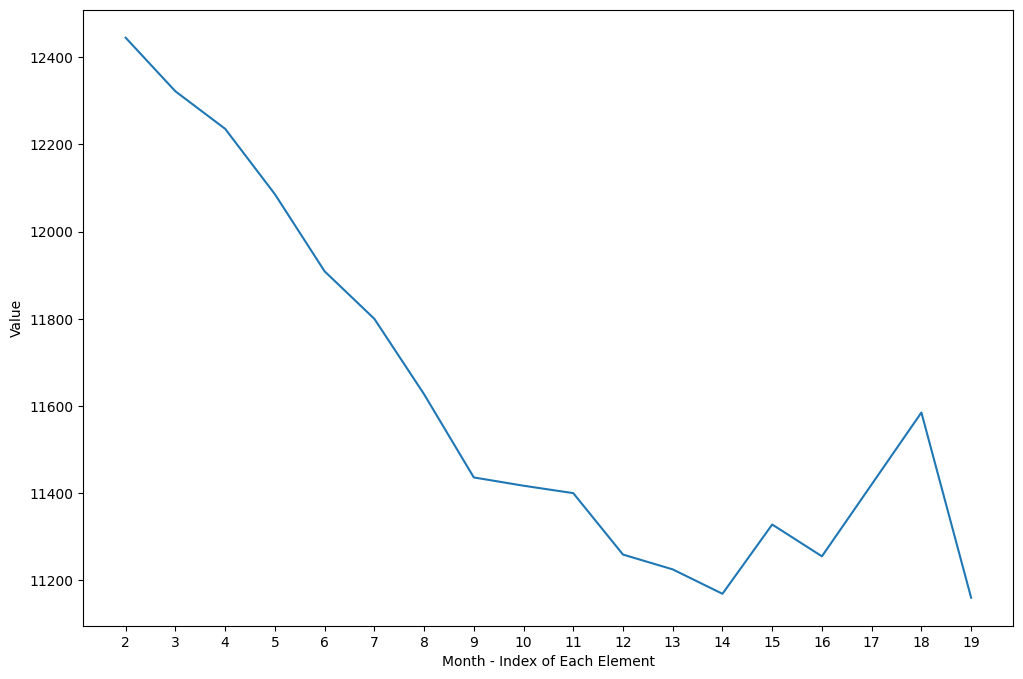

In [78]:
# This is for the testing dataset
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='index', y='items', data=df_3) # Revised based on how I formatted the dataset.
plt.xlabel('Month - Index of Each Element')
plt.ylabel('Value')

## **Data Testing - Basic**
We prepare the training set and test set data and work with using basic GPs. The data needs to be converted to tensors to work, so some precision of the data is lost. The data is converted to int32 tensors.

In [79]:
# From the newly created training dataset df_2
y_train = df_2["index"] # Months
y_train = torch.from_numpy(y_train.values.astype(np.int32))

x_train = df_2["items"] # Values
x_train = torch.from_numpy(x_train.values.astype(np.int32))

# From the newly created testing dataset df_3
y_test = df_3["index"] # Months
y_test = torch.from_numpy(y_test.values.astype(np.int32))

x_test = df_3["items"] # Values
x_test = torch.from_numpy(x_test.values.astype(np.int32))

In [82]:
# Using the tutorial code for the simplified testing and training with the dataset.
# Will need to change the GPModel being used as needed.
class GPModel(gp.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.RQKernel()) # Most effective of the combinations I tried, but by the 100th test, the negative LL is still 3023.869.
        # elf.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel() * gp.kernels.PeriodicKernel() + gp.kernels.LinearKernel() * gp.kernels.PeriodicKernel()) - This gives low initial losses, but they increase once we go past the 50th round. 
        # self.covar_module.initialize_from_data(x_train.type(torch.float32), y_train.type(torch.float32)) # Only for the SpectralMixture Kernel
  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gp.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gp.likelihoods.GaussianLikelihood()
model = GPModel(x_train, y_train, likelihood)

In [83]:
# This takes between 1-16 minutes on my laptop, for reference

# Running the notebook in the tutorial's testing framework
import os
smoke_test = ("CI" in os.environ)
training_iter = 2 if smoke_test else 100

# Finding the optimal parameters for the model
model.train()
likelihood.train()

# Using the ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# Finding the marginal log likelihood, or the "loss" for GPs
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
  optimizer.zero_grad()
  output = model(x_train)
  loss = -mll(output, y_train)
  loss.backward()
  print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
  optimizer.step()

Iter 1/100 - Loss: 197304.750
Iter 2/100 - Loss: 174212.266
Iter 3/100 - Loss: 152166.000
Iter 4/100 - Loss: 131428.000
Iter 5/100 - Loss: 111456.094
Iter 6/100 - Loss: 92419.953
Iter 7/100 - Loss: 75613.055
Iter 8/100 - Loss: 60611.605
Iter 9/100 - Loss: 47814.535
Iter 10/100 - Loss: 37475.309
Iter 11/100 - Loss: 29363.359
Iter 12/100 - Loss: 23213.209
Iter 13/100 - Loss: 18626.404
Iter 14/100 - Loss: 15233.229
Iter 15/100 - Loss: 12726.563
Iter 16/100 - Loss: 10865.352
Iter 17/100 - Loss: 9461.849
Iter 18/100 - Loss: 8394.845
Iter 19/100 - Loss: 7570.997
Iter 20/100 - Loss: 6913.093
Iter 21/100 - Loss: 6395.877
Iter 22/100 - Loss: 5972.451
Iter 23/100 - Loss: 5632.510
Iter 24/100 - Loss: 5350.152
Iter 25/100 - Loss: 5118.458
Iter 26/100 - Loss: 4925.631
Iter 27/100 - Loss: 4772.167
Iter 28/100 - Loss: 4628.985
Iter 29/100 - Loss: 4514.737
Iter 30/100 - Loss: 4394.474
Iter 31/100 - Loss: 4307.412
Iter 32/100 - Loss: 4210.196
Iter 33/100 - Loss: 4154.626
Iter 34/100 - Loss: 4075.548
It

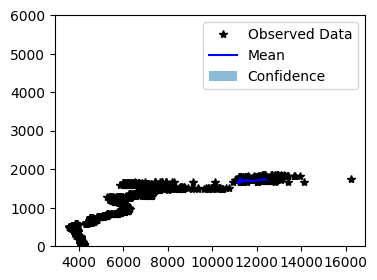

In [84]:
# Get into evaluation mode, or the predictive posterior mode
model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    # Making predictions
    observed_pred = likelihood(model(x_test))

    # Initializing the plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Getting the upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plotting training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plotting predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shading the region between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([0, 6000])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## **Data Testing - Less Basic**
We prepare the training set and test set data and work with using non-standard GPs.

In [ ]:
# Importing and installing sts so it can be used later on. This does not work. I need to fix this.
!pip install https://github.com/jpchen/autoforecasting/tree/master/sts

In [ ]:
from sts.gp.model import AdditiveSpectralMixtureTimeSeriesExactGPModel
from sts.gp.kernel import WhiteNoiseKernel
from gpytorch.kernels import LinearKernel, RBFKernel

likelihood = gp.likelihoods.GaussianLikelihood()
model = AdditiveSpectralMixtureTimeSeriesExactGPModel(df_train, likelihood)
model.cov.add_seasonality(
            time_axis="timestamp", period_length=365.25, fix_period=True
        )
model.cov.add_trend(
    time_axis="timestamp", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="timestamp",
    kernel_cls=RBFKernel,
    lengthscale=100,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="timestamp",
    num_mixtures=2,
    train_x=df_train.tensor,
    train_y=y_train.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="timestamp",
    num_mixtures=2,
    train_x=df_train.tensor,
    train_y=y_train.tensor,
    name="SM2",
)


# Training loop
We train our model with our training set, and show the training time below.

In [ ]:
learning_rate = 0.01
num_epochs = 3000
trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(df_train, y_train)
        if (epoch + 1) % 200 == 1:
            print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

# Predictions
We use our model to forecast the test set.



In [ ]:
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

transform = ComposeTransform([y_train.transforms['log_value'].inv, ExpTransform()])
train_mean, train_var, train_ci = get_mvn_stats(model.predict(df_train), transform)
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test), transform)

# This will need to be fixed based on how I created the training and testing datsets.
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(df['timestamp'][:num_trainset], train_mean, alpha=0.8, color='blue', linewidth=1, label='train')
ax.plot(df['timestamp'][num_trainset:], test_mean, alpha=0.8, color='green', linewidth=1, label='test')
ax.plot(df['timestamp'], df['value'], 'o', markersize=1, color='black', label='actual')
ax.fill_between(df['timestamp'], torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]]), alpha=0.2, label='ci', color='gray')
ax.legend()


The training set has tight credible intervals, while that of the test set is wider. This makes sense since the credible interval gets larger if we extrapolate from the data. But still, we would like to see better performance in the forecasting part.


# Kernel Decomposition
We decompose additive kernels to see how each kernel functions.

In [ ]:
from sts.gp.graph import plot_components

x_all = torch.cat([df_train.tensor, x_test.tensor])
components = model.decompose_timeseries(x_all)
fig, ax = plot_components(df['timestamp'], components[1], y=model.predict(x_all), transform=transform)

# Evaluation
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [ ]:
train_mean, train_var, train_ci = get_mvn_stats(model.predict(df_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))


Here we compute MAE for both training data and test data.

In [ ]:
from sts.metrics import MAE
MAE_train = MAE(y_train.tensor, train_mean).item()
MAE_test = MAE(y_test.tensor, test_mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Here we compute CRPS for both training data and test data.

In [ ]:
from sts.crps import crps_gaussian
crps_train = crps_gaussian(y_train.tensor, train_mean, train_var.sqrt())
crps_test = crps_gaussian(y_test.tensor, test_mean, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

Here we compute log-likelihood for both training data and test data.



In [ ]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, y_train.tensor, train_var).item()
ll_test = log_likelihood_error(test_mean, y_test.tensor, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

In [ ]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_meature = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_meature

Above is the table showing the values of each metrics, where the first line is for the training set and the second line is for the test set. As a kind reminder, MAE and CRPS are better if they are lower, while LL is better when it's higher.


At the same time, we noticed the training set shows higher accuracy than the test set. To improve this, we will assign priors to the hyperparameters and use the hierarchical priors to gain joint information of univarite time series.

# References

[1] Corani, G., Benavoli, A., Augusto, J. and Zaffalon, M., 2020. Automatic Forecasting using Gaussian Processes. arXiv preprint arXiv:2009.08102.